In [59]:
import sys; sys.path.insert(0, '../')

import matplotlib.pyplot as plt
import torch
import json
import pyqg_subgrid_experiments as pse
from models.cgan_model import CGANModel
from models.mean_var_model import MeanVarModel
from tools.plot_helpers import *
from tools.computational_tools import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train = pse.Dataset('/scratch/pp2681/pyqg_NN/mean_var/train.nc')

In [3]:
test = pse.Dataset('/scratch/pp2681/pyqg_NN/mean_var/test.nc')

In [4]:
folder = '/scratch/pp2681/pyqg_NN/CGAN_residual/'
exps = ('EXP1', 'EXP2', 'EXP3', 'EXP4', 'EXP5')

In [5]:
ds = {}
for exp in exps:
    ds[exp] = read_experiment(folder+exp)

for exp in exps:
    print(exp, ds[exp]['args'])    

EXP1 {'n_latent': 1, 'minibatch_discrimination': 0, 'deterministic': 0, 'loss_type': 'WGAN', 'lambda_MSE_mean': 0.0, 'lambda_MSE_sample': 0.0, 'num_epochs': 200, 'ensemble_size': 100}
EXP2 {'n_latent': 1, 'minibatch_discrimination': 0, 'deterministic': 1, 'loss_type': 'WGAN', 'lambda_MSE_mean': 0.0, 'lambda_MSE_sample': 0.0, 'num_epochs': 200, 'ensemble_size': 100}
EXP3 {'n_latent': 1, 'minibatch_discrimination': 1, 'deterministic': 0, 'loss_type': 'WGAN', 'lambda_MSE_mean': 0.0, 'lambda_MSE_sample': 0.0, 'num_epochs': 200, 'ensemble_size': 100}
EXP4 {'n_latent': 2, 'minibatch_discrimination': 1, 'deterministic': 0, 'loss_type': 'WGAN', 'lambda_MSE_mean': 0.0, 'lambda_MSE_sample': 0.0, 'num_epochs': 200, 'ensemble_size': 100}
EXP5 {'n_latent': 1, 'minibatch_discrimination': 1, 'deterministic': 0, 'loss_type': 'GAN', 'lambda_MSE_mean': 0.0, 'lambda_MSE_sample': 0.0, 'num_epochs': 200, 'ensemble_size': 100}


# Shanspots of predictions

In [49]:
def show_prediction(ds, truth, exp, lev=0, title=''):
    prediction = ds[exp]['test'].isel(run=1, time=-1, lev=lev)
    truth = test.isel(run=1, time=-1, lev=lev)
    with pse.figure_grid(1,5) as g:
        g.next('residual of forcing PV')
        pse.imshow(prediction.q_forcing_advection_res)
        g.next('residual sample')
        pse.imshow(prediction.q_forcing_advection_res_gen)
        g.next('residual sample mean')
        pse.imshow(prediction.q_forcing_advection_res_gen_mean)
        g.next('residual sample std')
        pse.imshow(prediction.q_forcing_advection_res_gen_std)
        g.next('ground truth std')
        pse.imshow(truth.q_forcing_advection_std)
        plt.suptitle(title)

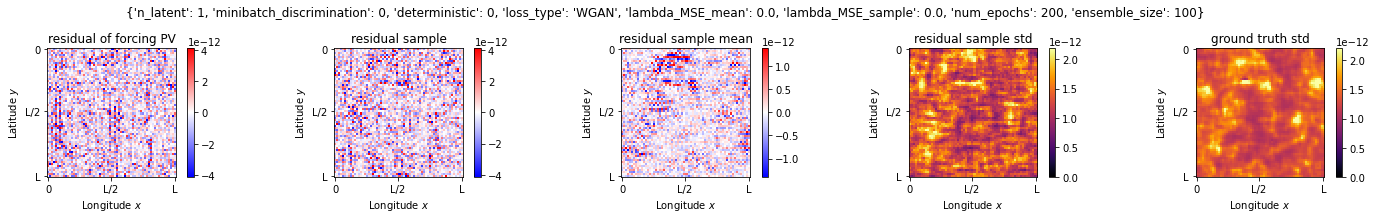

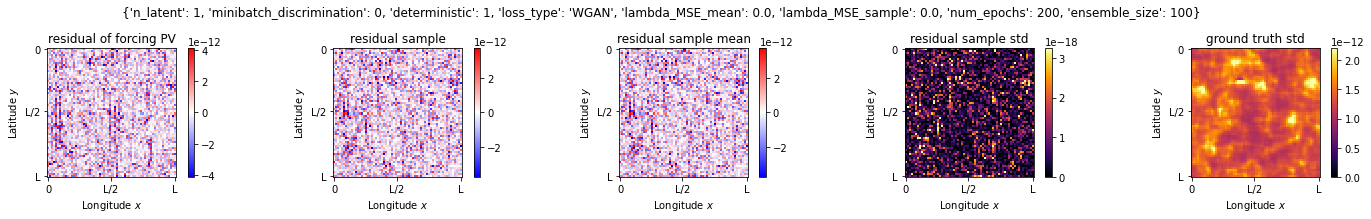

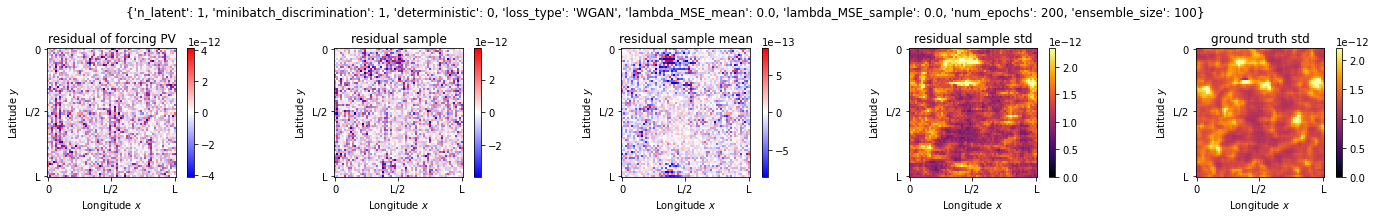

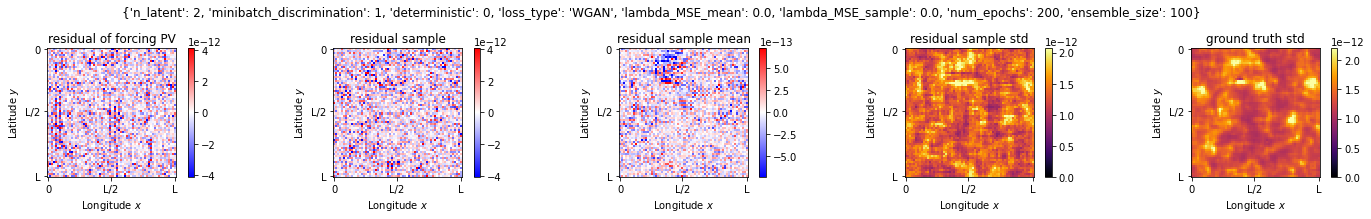

In [52]:
show_prediction(ds, test, 'EXP1', title=ds['EXP1']['args'])
show_prediction(ds, test, 'EXP2', title=ds['EXP2']['args'])
show_prediction(ds, test, 'EXP3', title=ds['EXP3']['args'])
show_prediction(ds, test, 'EXP4', title=ds['EXP4']['args'])

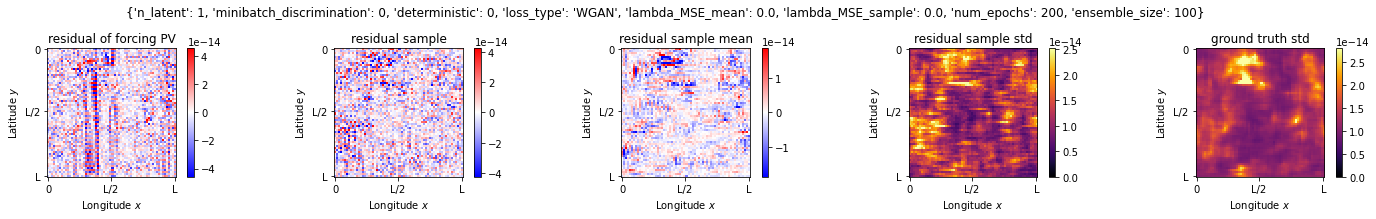

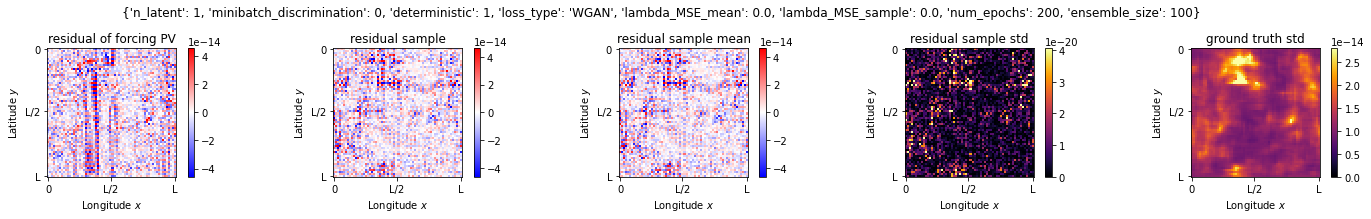

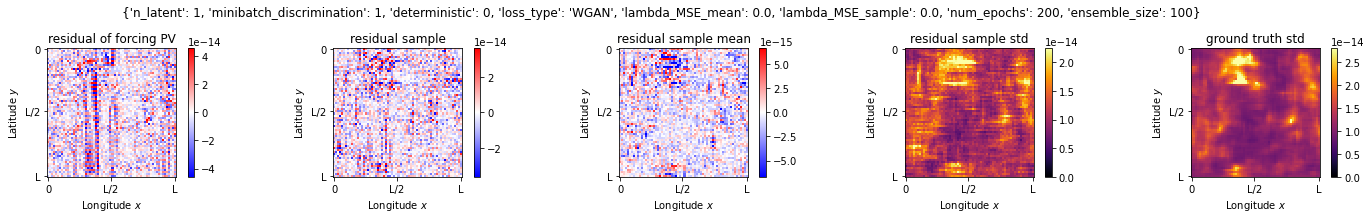

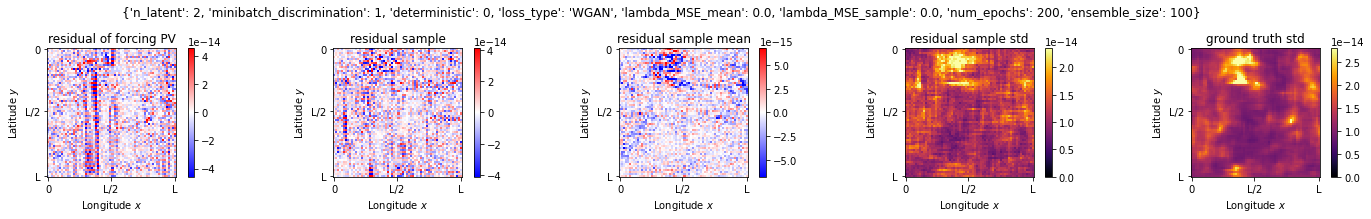

In [51]:
show_prediction(ds, test, 'EXP1', lev=1, title=ds['EXP1']['args'])
show_prediction(ds, test, 'EXP2', lev=1, title=ds['EXP2']['args'])
show_prediction(ds, test, 'EXP3', lev=1, title=ds['EXP3']['args'])
show_prediction(ds, test, 'EXP4', lev=1, title=ds['EXP4']['args'])

# Analysis of total variance

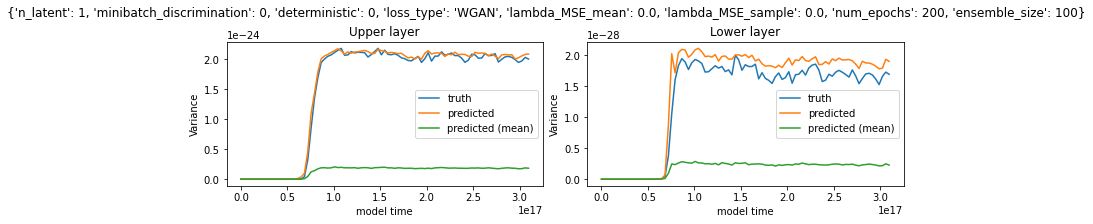

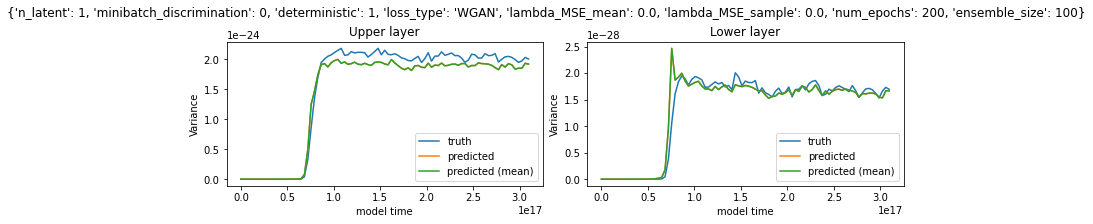

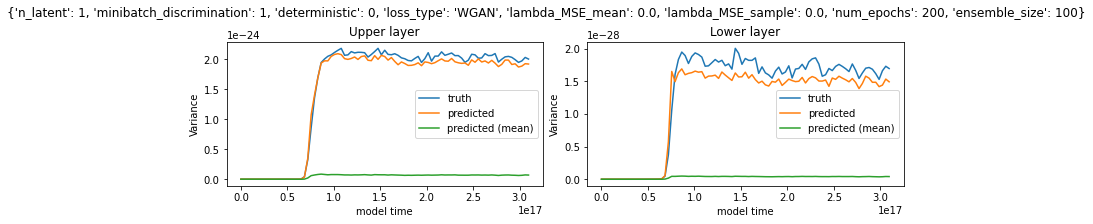

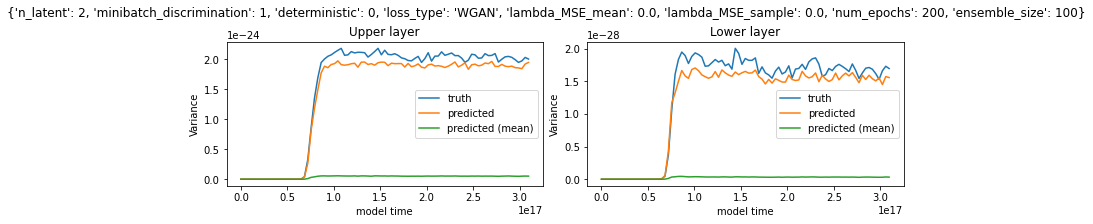

In [143]:
def plot_variance(exp):
    fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(10,3))
    ax=ax.ravel()
    (ds[exp]['test'].q_forcing_advection_res**2).mean(dim=('run','x','y')).isel(lev=0).plot(label='truth', ax=ax[0])
    (ds[exp]['test'].q_forcing_advection_res_gen**2).mean(dim=('run','x','y')).isel(lev=0).plot(label='predicted', ax=ax[0])
    (ds[exp]['test'].q_forcing_advection_res_gen_mean**2).mean(dim=('run','x','y')).isel(lev=0).plot(label='predicted (mean)', ax=ax[0])
    ax[0].set_ylabel('Variance')
    ax[0].legend()
    ax[0].set_title('Upper layer')
    (ds[exp]['test'].q_forcing_advection_res**2).mean(dim=('run','x','y')).isel(lev=1).plot(label='truth', ax=ax[1])
    (ds[exp]['test'].q_forcing_advection_res_gen**2).mean(dim=('run','x','y')).isel(lev=1).plot(label='predicted', ax=ax[1])
    (ds[exp]['test'].q_forcing_advection_res_gen_mean**2).mean(dim=('run','x','y')).isel(lev=1).plot(label='predicted (mean)', ax=ax[1])
    ax[1].set_ylabel('Variance')
    ax[1].legend()
    ax[1].set_title('Lower layer')

    plt.suptitle(ds[exp]['args'])
plot_variance('EXP1')
plot_variance('EXP2')
plot_variance('EXP3')
plot_variance('EXP4')

# Compared to the case where we generate full subgrid force, but not residual, MSE errors no longer show quality of prediction

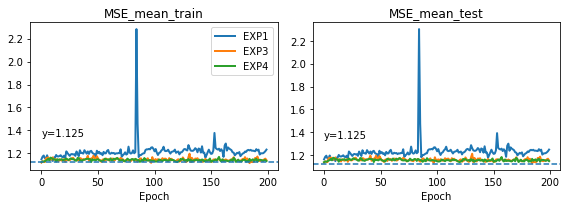

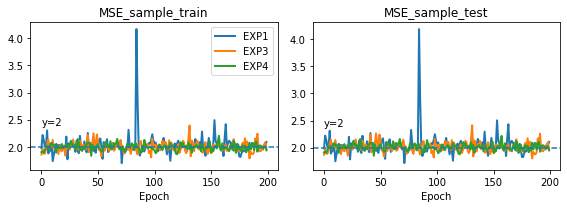

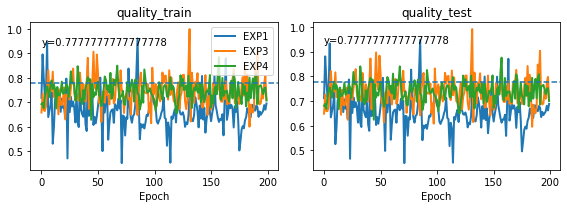

In [187]:
plot_lines(ds, ('EXP1', 'EXP3', 'EXP4'), ('MSE_mean_train','MSE_mean_test'), ('EXP1', 'EXP3', 'EXP4'), hline=(1+1/8))
plot_lines(ds, ('EXP1', 'EXP3', 'EXP4'), ('MSE_sample_train', 'MSE_sample_test'), ('EXP1', 'EXP3', 'EXP4'), hline=2)
plot_lines(ds, ('EXP1', 'EXP3', 'EXP4'), ('quality_train', 'quality_test'), ('EXP1', 'EXP3', 'EXP4'), hline=(2-1.125)/1.125)

# Spectral content

In [38]:
def plot_sp(dataset, exp, z=0):
    fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(12,4))
    ax = ax.ravel()
    ds = pse.Dataset(dataset[exp]['test'])
    file = dataset[exp]['test'].isel(time=slice(44,None))
    
    GZ = file.q_forcing_advection_res_gen_std
    GZ = np.random.randn(*GZ.shape) * GZ
    
    k, sp = isotropic_spectrum_compute(ds, file.q_forcing_advection_res, z=z, truncate=False, averaging=False)
    ax[0].plot(k,sp,'--k',label='Residual')
    k, sp = isotropic_spectrum_compute(ds, file.q_forcing_advection_res_gen, z=z, truncate=False, averaging=False)
    ax[0].plot(k,sp,label='Generated residual')
    k, sp = isotropic_spectrum_compute(ds, file.q_forcing_advection_res_gen_mean, z=z, truncate=False, averaging=False)
    ax[0].plot(k,sp,label='Sample mean residual')
    k, sp = isotropic_spectrum_compute(ds, GZ, z=z, truncate=False, averaging=False)
    ax[0].plot(k,sp,label='white noise')
    ax[0].set_xlabel('wavenumber, $m^{-1}$')
    ax[0].set_ylabel('Power spectral density of dq/dt [$m/s^4$]')
    ax[0].set_title('Power spectrum of residuals')
    ax[0].set_xticks([0, 1e-4, 2e-4])
    ax[0].legend()
    dx = np.diff(ds.x)[0]
    ax[0].axvline(x=np.pi/dx, linestyle=':', color='k', label='Grid cutoff = $\pi/dx$')
    
    k, sp = isotropic_spectrum_compute(ds, file.q_forcing_advection_res, z=z, truncate=False, averaging=False)
    ax[1].loglog(k,sp,'--k',label='Residual')
    k, sp = isotropic_spectrum_compute(ds, file.q_forcing_advection_res_gen, z=z, truncate=False, averaging=False)
    ax[1].loglog(k,sp,label='Generated residual')
    k, sp = isotropic_spectrum_compute(ds, file.q_forcing_advection_res_gen_mean, z=z, truncate=False, averaging=False)
    ax[1].loglog(k,sp,label='Sample mean residual')
    k, sp = isotropic_spectrum_compute(ds, GZ, z=z, truncate=False, averaging=False)
    ax[1].loglog(k,sp,label='white noise')
    ax[1].set_xlabel('wavenumber, $m^-1$')
    ax[1].set_ylabel('Power spectral density of dq/dt [$m/s^4$]')
    ax[1].set_title('Power spectrum of residuals')
    ax[1].legend()
    dx = np.diff(ds.x)[0]
    ax[1].axvline(x=np.pi/dx, linestyle=':', color='k', label='Grid cutoff = $\pi/dx$')
    plt.suptitle(dataset[exp]['args'])

# Upper layer

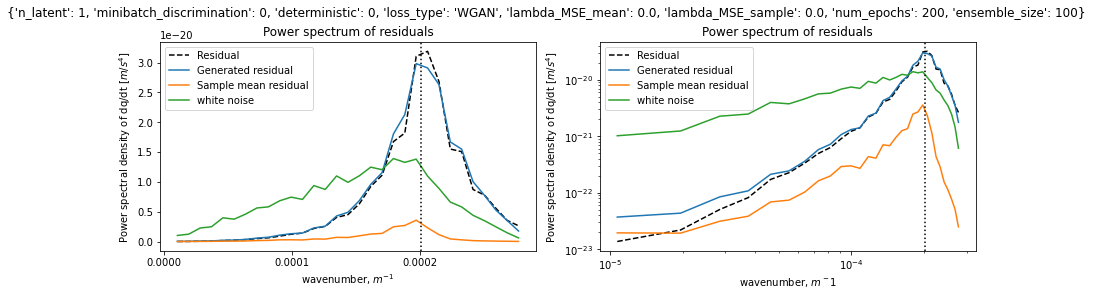

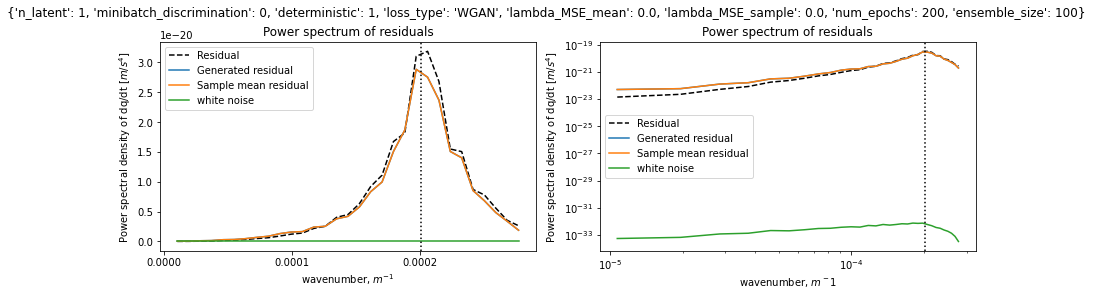

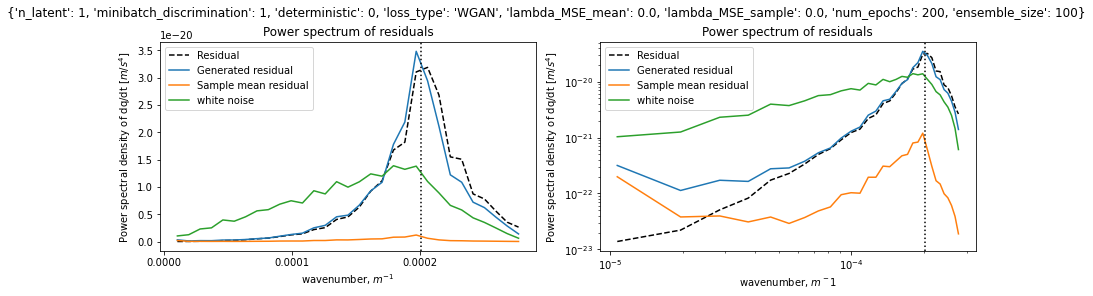

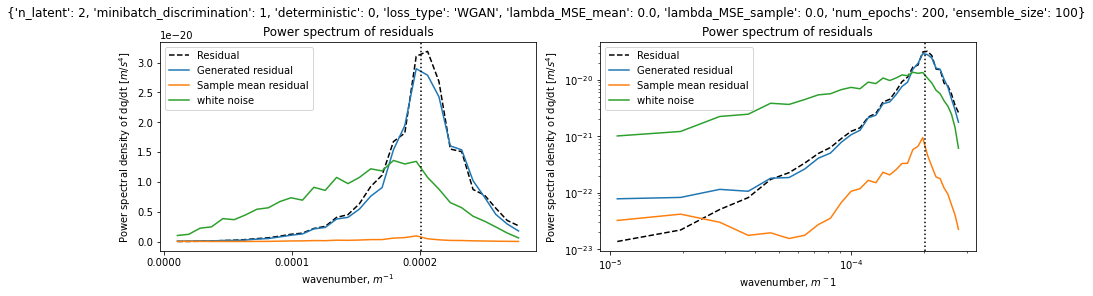

In [39]:
plot_sp(ds, 'EXP1')
plot_sp(ds, 'EXP2')
plot_sp(ds, 'EXP3')
plot_sp(ds, 'EXP4')

# Lower layer

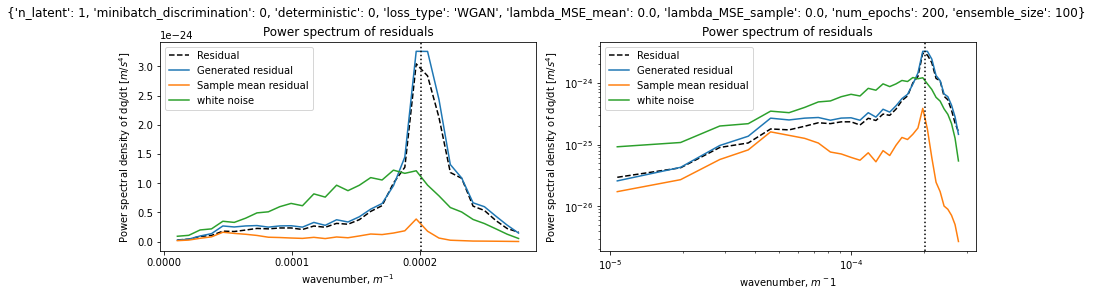

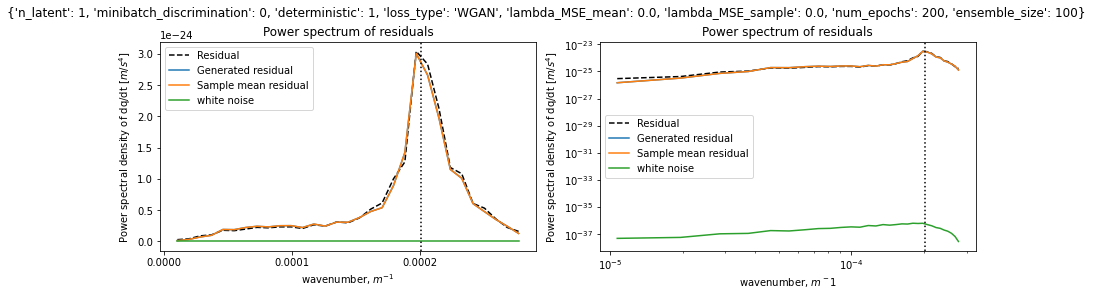

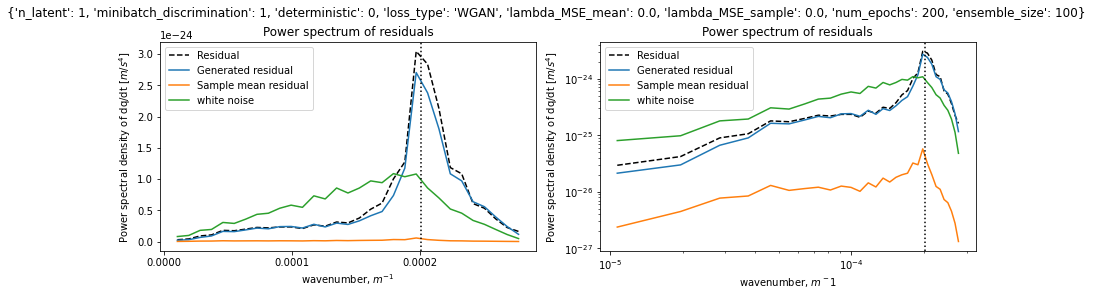

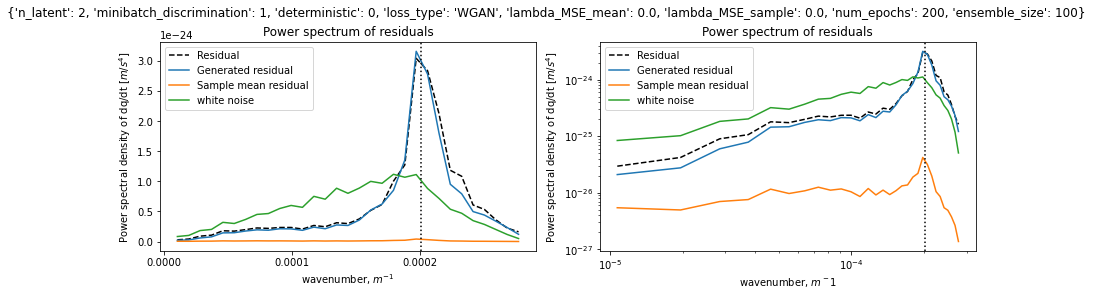

In [40]:
plot_sp(ds, 'EXP1', z=1)
plot_sp(ds, 'EXP2', z=1)
plot_sp(ds, 'EXP3', z=1)
plot_sp(ds, 'EXP4', z=1)

# PDF analysis of residuals and generated ones

# Upper layer

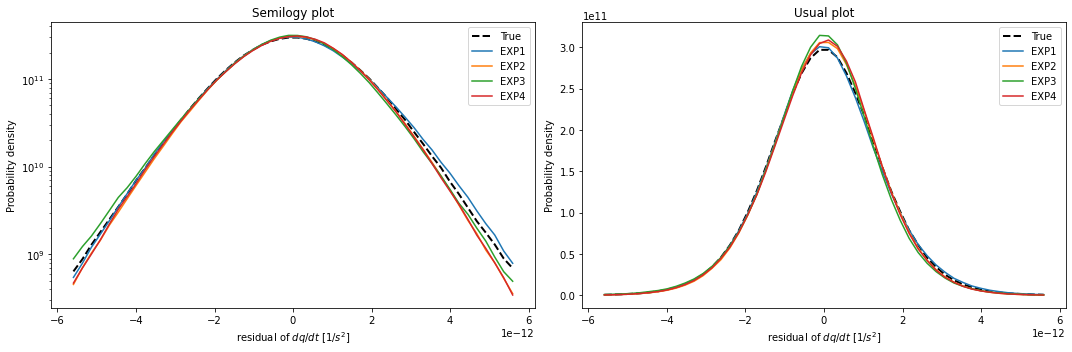

In [55]:
plot_PDF(ds, ('EXP1', 'EXP2', 'EXP3', 'EXP4'), ('EXP1', 'EXP2', 'EXP3', 'EXP4'), variable='q_forcing_advection_res')

# Lower layer

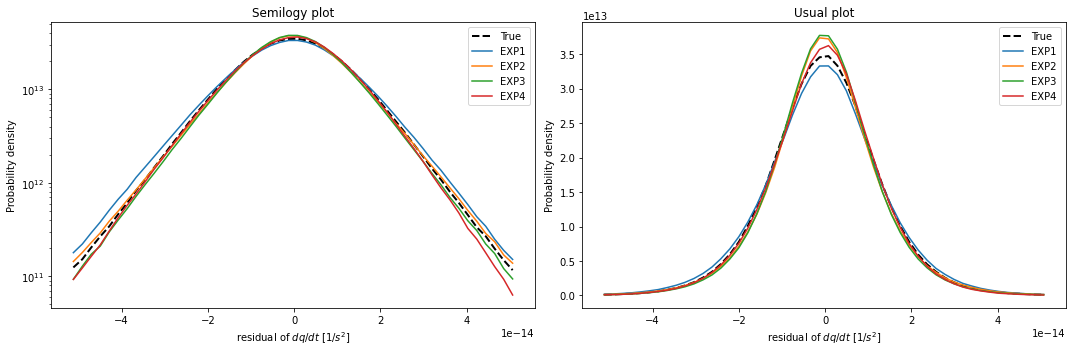

In [56]:
plot_PDF(ds, ('EXP1', 'EXP2', 'EXP3', 'EXP4'), ('EXP1', 'EXP2', 'EXP3', 'EXP4'), variable='q_forcing_advection_res', lev=1)

# Cross spectrum of residuals across layers

In [88]:
def plot_cospectrum(dataset, exp):
    fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(6,4))
    ds = pse.Dataset(dataset[exp]['test'])
    file = dataset[exp]['test'].isel(time=slice(44,None))
    
    GZ = file.q_forcing_advection_res_gen_std
    GZ = np.random.randn(*GZ.shape) * GZ
    
    k, sp = isotropic_cross_spectrum_compute(ds, file.q_forcing_advection_res, truncate=False, averaging=False)
    ax.plot(k,sp,'--k',label='Residual')
    k, sp = isotropic_cross_spectrum_compute(ds, file.q_forcing_advection_res_gen, truncate=False, averaging=False)
    ax.plot(k,sp,label='Generated residual')
    k, sp = isotropic_cross_spectrum_compute(ds, GZ, truncate=False, averaging=False)
    ax.plot(k,sp,label='white noise')
    ax.set_xlabel('wavenumber, $m^{-1}$')
    ax.set_ylabel('Cospectrum between layers of dq/dt [$m/s^4$]')
    ax.set_title('Cospectrum between layers of residual')
    ax.set_xticks([0, 1e-4, 2e-4])
    ax.legend()
    dx = np.diff(ds.x)[0]
    ax.axvline(x=np.pi/dx, linestyle=':', color='k', label='Grid cutoff = $\pi/dx$')
    plt.suptitle(dataset[exp]['args'])

Corr coeff =  -0.06774735062659386
Corr coeff =  -0.01907409880186921
Corr coeff =  4.6861171838289214e-05
Corr coeff =  -0.06774735062659386
Corr coeff =  -0.07234169298933102
Corr coeff =  -0.001126690211246744
Corr coeff =  -0.06774735062659386
Corr coeff =  -0.14454314151068073
Corr coeff =  0.0001434717736488112
Corr coeff =  -0.06774735062659386
Corr coeff =  -0.08808664022433602
Corr coeff =  0.0002879874915081751


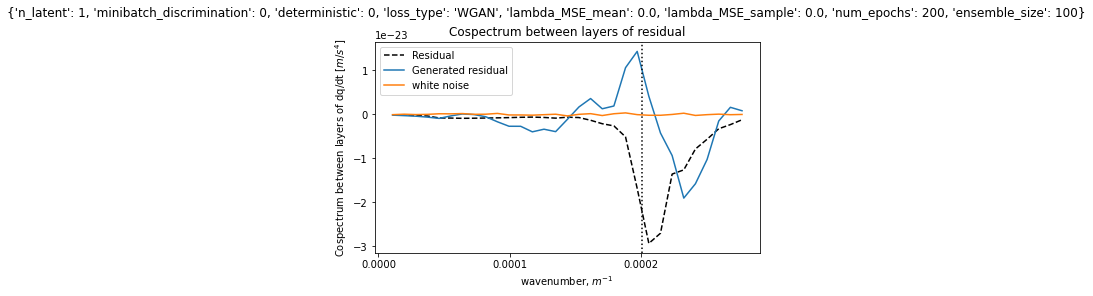

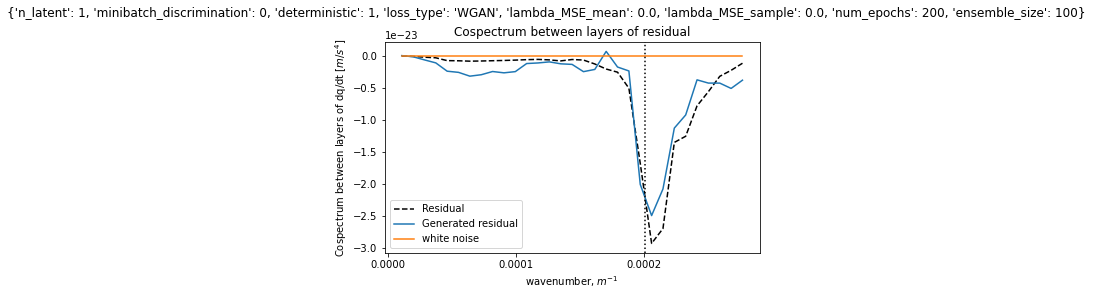

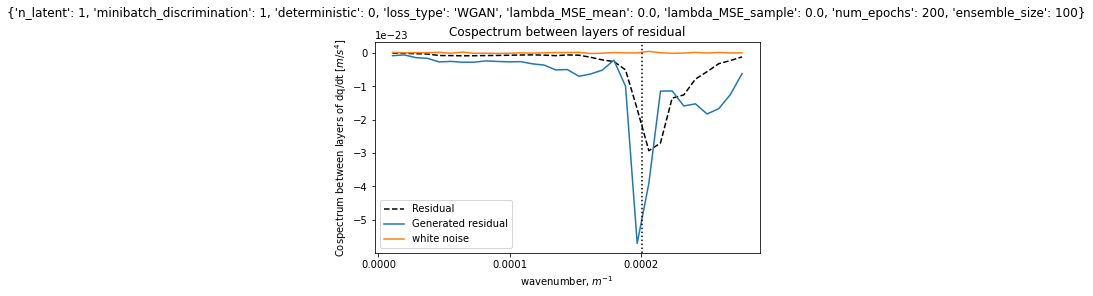

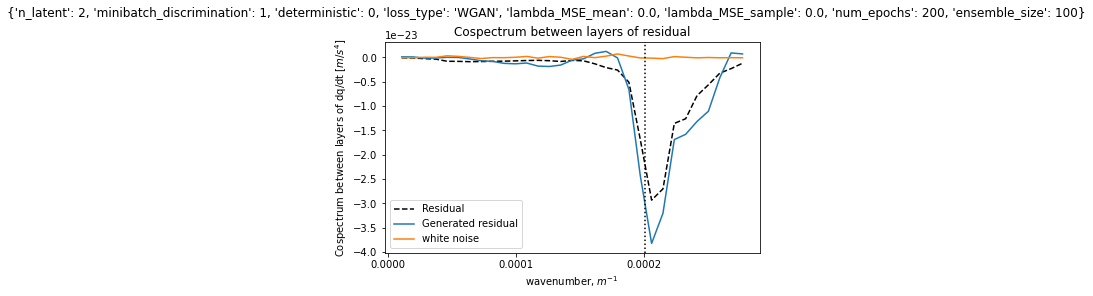

In [100]:
plot_cospectrum(ds, 'EXP1')
plot_cospectrum(ds, 'EXP2')
plot_cospectrum(ds, 'EXP3')
plot_cospectrum(ds, 'EXP4')